**CNN with Group Normalization and Weight Standarization**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
# Load your CSV dataset (replace 'your_dataset.csv' with your actual dataset)
data = pd.read_csv('/content/drive/MyDrive/ML/Thesis/Detection/Obfuscated-MalMem2022-v3.csv')
from sklearn.preprocessing import LabelEncoder
lab=LabelEncoder()
data['class']=lab.fit_transform(data['Class'])
#data['category']=lab.fit_transform(data['Category'])
#data['family']=lab.fit_transform(data['Family'])
data = data.drop(['Class'], axis=1)
data = data.drop(['Category'], axis=1)
data = data.drop(['Family'], axis=1)
#columns with 0 values
data = data.drop(['pslist.nprocs64bit'], axis=1)
data = data.drop(['handles.nport'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool_false_avg'], axis=1)
data = data.drop(['svcscan.interactive_process_services'], axis=1)
data = data.drop(['callbacks.nanonymous'], axis=1)
data = data.drop(['modules.nmodules'], axis=1)
data = data.drop(['callbacks.ngeneric'], axis=1)
data = data.drop(['svcscan.fs_drivers'], axis=1)

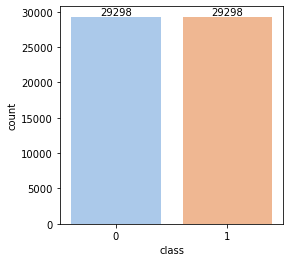

In [ ]:
plt.figure(figsize=(4,4))
ax = sns.countplot(x='class',data=data,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [ ]:
labels=["Benign","Malware"]

fraud_or_not = data["class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=data['class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["green","black"]
             ,title="Benign (Green) , Malware (black)")
fig.show()

<h3>Normalization</h3>

In [4]:
from sklearn.preprocessing import MinMaxScaler
# Create a Min-Max scaler instance
scaler = MinMaxScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = data.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [6]:
# Split the dataset into features (X) and labels (y)
X = data.drop(columns=["class"]).values
y = data["class"].values
X.shape

(58596, 46)

<h3>CNN_2 with 20 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Mean Accuracy: 99.94%
Mean Training Time (seconds): 3.81
Mean Testing Time (seconds): 0.38
Mean Training Loss: 0.0047
Mean Test Loss: 0.0037


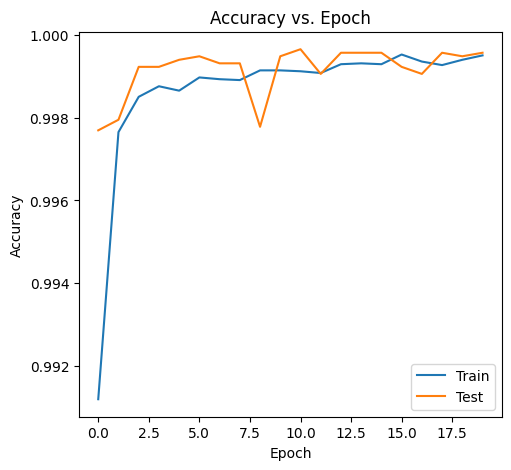

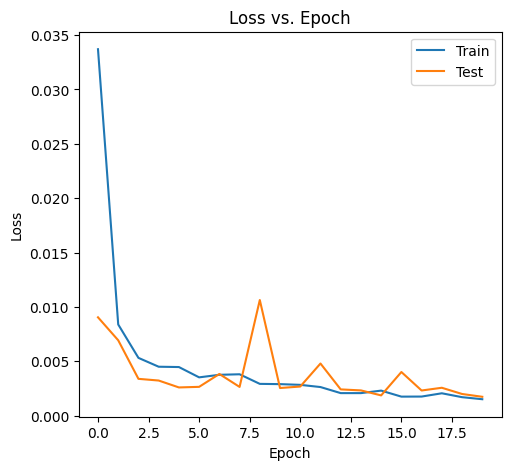

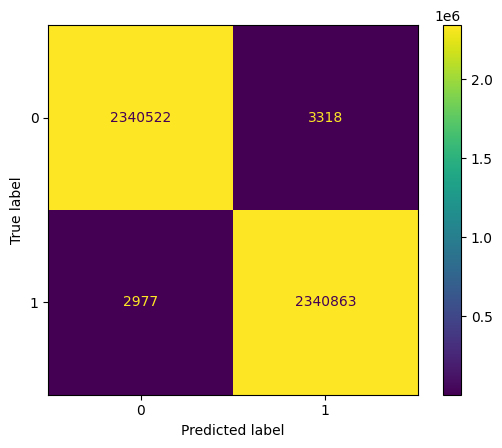

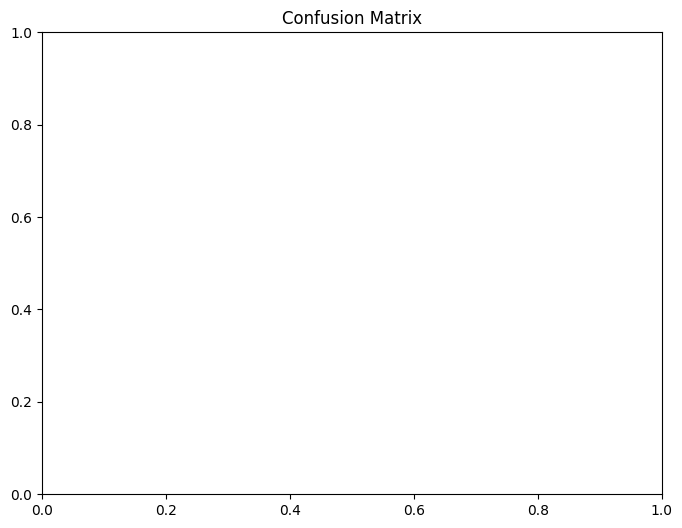

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert data to PyTorch tensors
# Replace these placeholders with your actual data
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5

# Initialize lists to store metrics
fold_accuracies = []
train_times = []
test_times = []
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Custom convolution layer with weight standardization
class Conv1dWS(nn.Conv1d):
    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return self._conv_forward(x, weight, self.bias)  # Pass self.bias here

# Define the CNN model with Group Normalization and Weight Standardization
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = Conv1dWS(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.groupnorm = nn.GroupNorm(num_groups=4, num_channels=32)
        self.fc = nn.Linear(32 * (input_size // 2), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.groupnorm(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 46  # Number of input features (adjust as needed)
    num_classes = len(np.unique(y.numpy()))  # Number of classes

    model = CNNModel(input_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    fold_accuracies.append(test_accuracies[-1])

mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

total_test_loss = sum(test_losses)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/20_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/20_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()
# Plot confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)
disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/20_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN_2 with 30 Epochs Implementation</h3>

<ipython-input-8-de8113b33a7a>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-8-de8113b33a7a>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)
Fold 5/5: 100%|██████████| 30/30 [01:48<00:00,  3.62s/it]


Mean Accuracy: 99.96%
Mean Training Time (seconds): 542.18
Mean Testing Time (seconds): 54.14
Mean Training Loss: 0.0037
Mean Test Loss: 0.0034


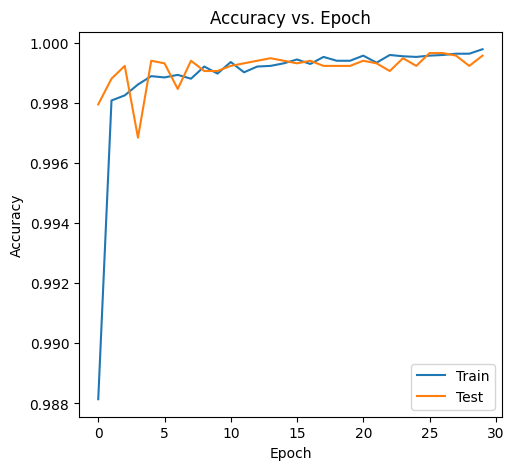

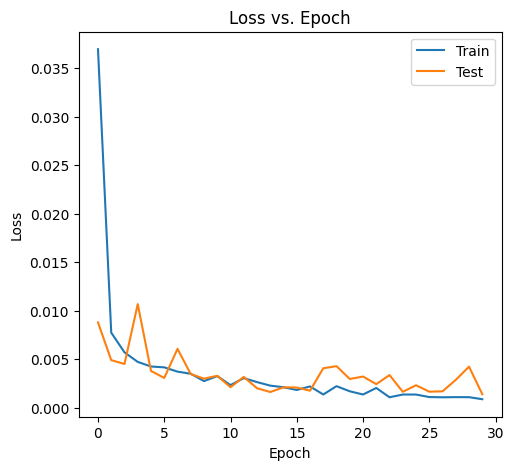

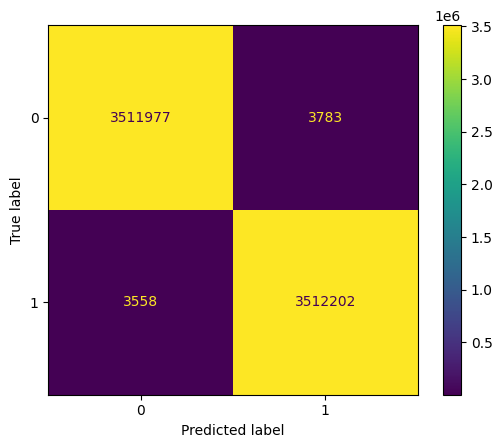

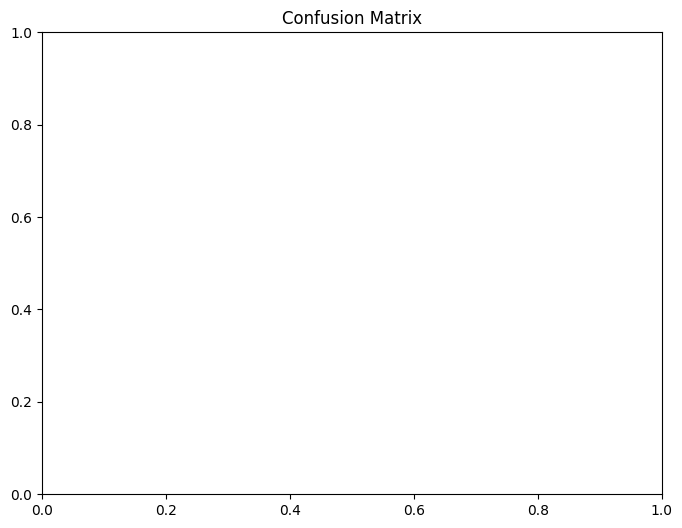

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert data to PyTorch tensors
# Replace these placeholders with your actual data
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5

# Initialize lists to store metrics
fold_accuracies = []
train_times = []
test_times = []
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Custom convolution layer with weight standardization
class Conv1dWS(nn.Conv1d):
    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return self._conv_forward(x, weight, self.bias)  # Pass self.bias here

# Define the CNN model with Group Normalization and Weight Standardization
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = Conv1dWS(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.groupnorm = nn.GroupNorm(num_groups=4, num_channels=32)
        self.fc = nn.Linear(32 * (input_size // 2), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.groupnorm(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 46  # Number of input features (adjust as needed)
    num_classes = len(np.unique(y.numpy()))  # Number of classes

    model = CNNModel(input_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 30
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    fold_accuracies.append(test_accuracies[-1])

mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

total_test_loss = sum(test_losses)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/30_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/30_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()
# Plot confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)
disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/30_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN_2 with 50 Epochs Implementation</h3>

> Indented block



<ipython-input-9-7a52074ce7b3>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-9-7a52074ce7b3>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)
Fold 5/5: 100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


Mean Accuracy: 99.95%
Mean Training Time (seconds): 889.86
Mean Testing Time (seconds): 89.34
Mean Training Loss: 0.0021
Mean Test Loss: 0.0024


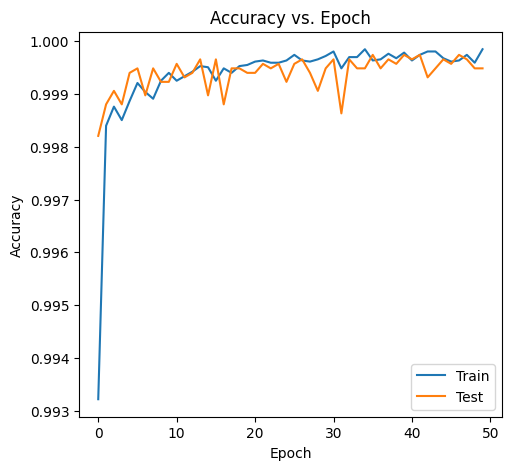

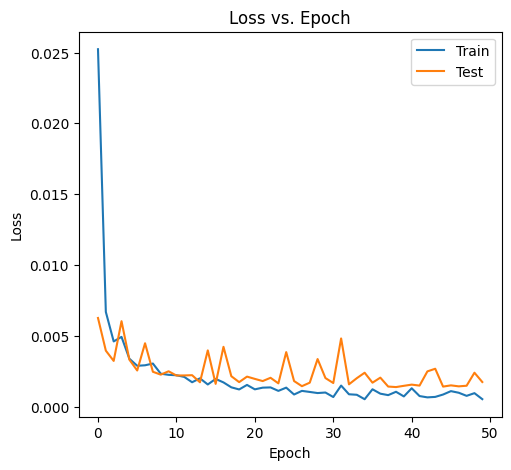

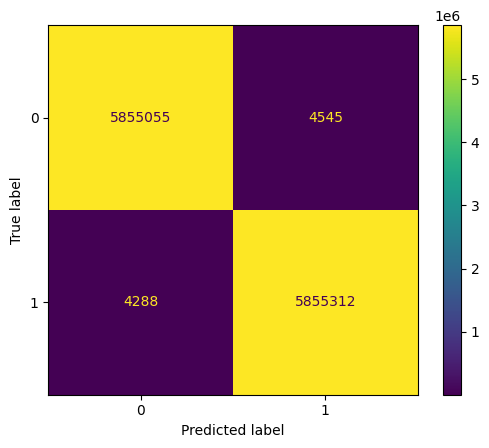

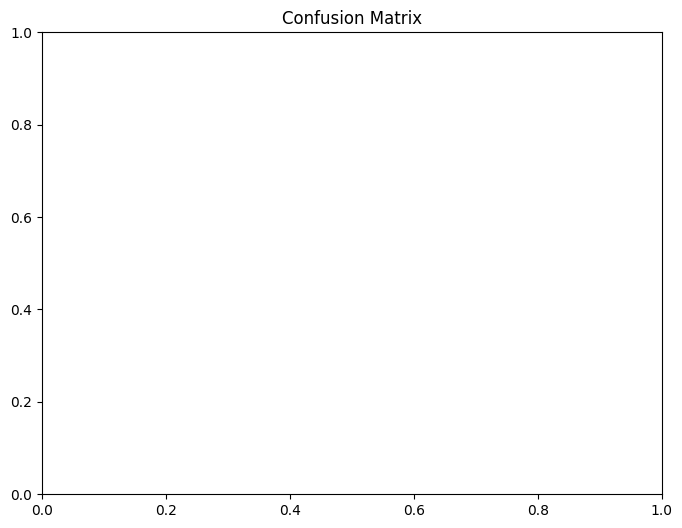

In [9]:
# Convert data to PyTorch tensors
# Replace these placeholders with your actual data
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5

# Initialize lists to store metrics
fold_accuracies = []
train_times = []
test_times = []
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Custom convolution layer with weight standardization
class Conv1dWS(nn.Conv1d):
    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return self._conv_forward(x, weight, self.bias)  # Pass self.bias here

# Define the CNN model with Group Normalization and Weight Standardization
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = Conv1dWS(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.groupnorm = nn.GroupNorm(num_groups=4, num_channels=32)
        self.fc = nn.Linear(32 * (input_size // 2), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.groupnorm(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 46  # Number of input features (adjust as needed)
    num_classes = len(np.unique(y.numpy()))  # Number of classes

    model = CNNModel(input_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    fold_accuracies.append(test_accuracies[-1])

mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

total_test_loss = sum(test_losses)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/50_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/50_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()
# Plot confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)
disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/50_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN_2 with 100 Epochs Implementation</h3>

1.   List item
2.   List item



<ipython-input-10-8c147b2f82af>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-10-8c147b2f82af>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)
Fold 5/5: 100%|██████████| 100/100 [06:05<00:00,  3.65s/it]


Mean Accuracy: 99.97%
Mean Training Time (seconds): 1818.95
Mean Testing Time (seconds): 181.69
Mean Training Loss: 0.0015
Mean Test Loss: 0.0024


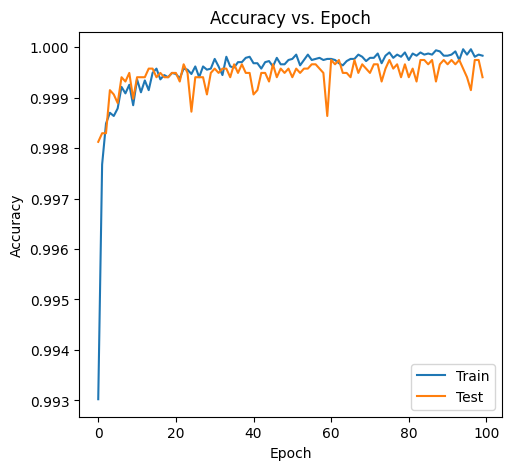

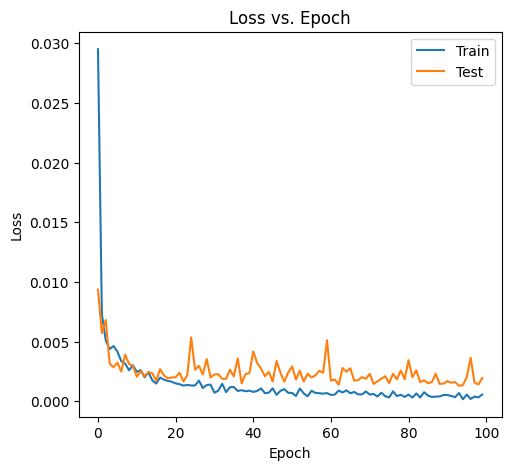

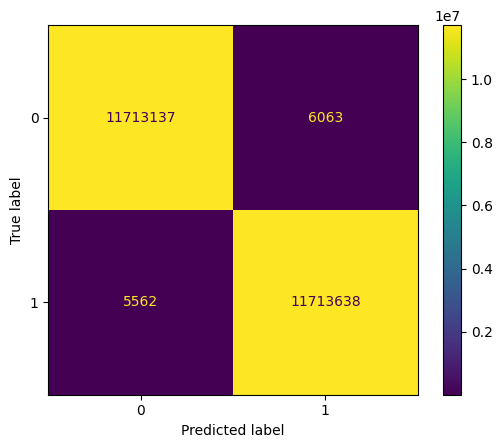

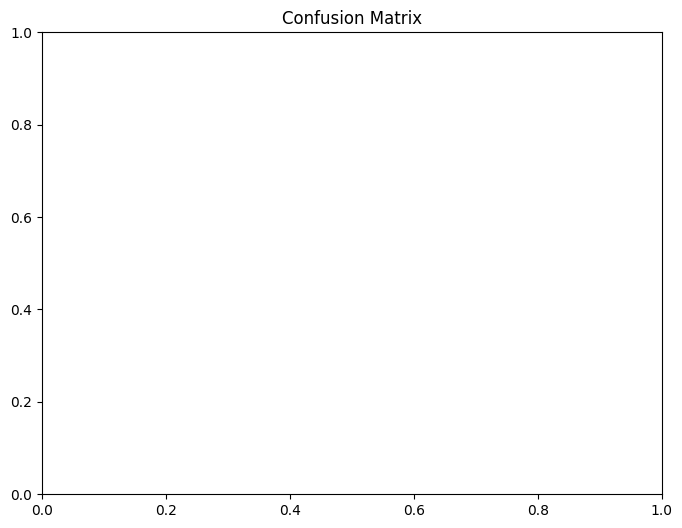

In [10]:
# Convert data to PyTorch tensors
# Replace these placeholders with your actual data
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5

# Initialize lists to store metrics
fold_accuracies = []
train_times = []
test_times = []
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Custom convolution layer with weight standardization
class Conv1dWS(nn.Conv1d):
    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return self._conv_forward(x, weight, self.bias)  # Pass self.bias here

# Define the CNN model with Group Normalization and Weight Standardization
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = Conv1dWS(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.groupnorm = nn.GroupNorm(num_groups=4, num_channels=32)
        self.fc = nn.Linear(32 * (input_size // 2), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.groupnorm(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 46  # Number of input features (adjust as needed)
    num_classes = len(np.unique(y.numpy()))  # Number of classes

    model = CNNModel(input_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    fold_accuracies.append(test_accuracies[-1])

mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

total_test_loss = sum(test_losses)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/100_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/100_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()
# Plot confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)
disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/100_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()

<h3>CNN_2 with 150 Epochs Implementation</h3>

<ipython-input-11-2af81dff412d>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-11-2af81dff412d>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)
Fold 5/5: 100%|██████████| 150/150 [09:26<00:00,  3.77s/it]


Mean Accuracy: 99.99%
Mean Training Time (seconds): 2793.81
Mean Testing Time (seconds): 277.08
Mean Training Loss: 0.0010
Mean Test Loss: 0.0018


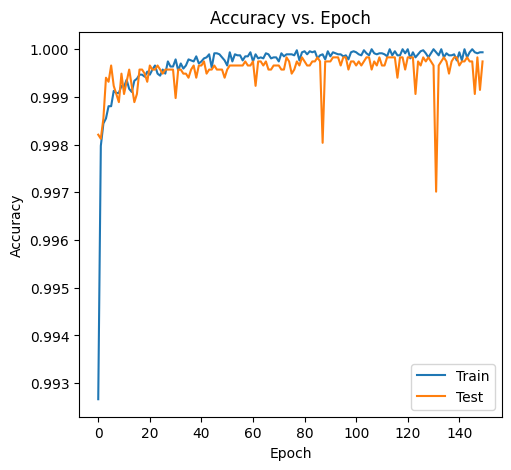

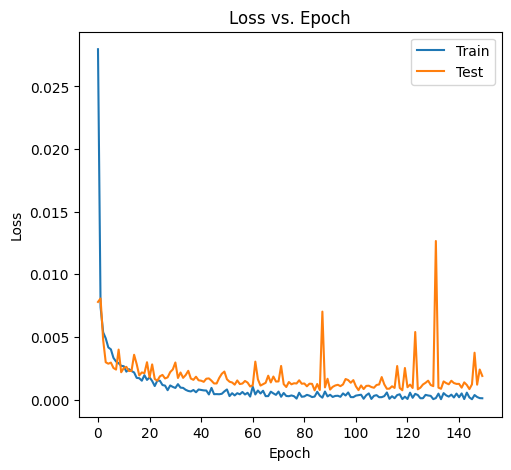

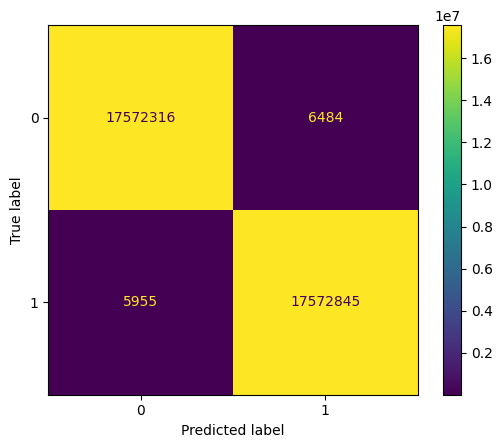

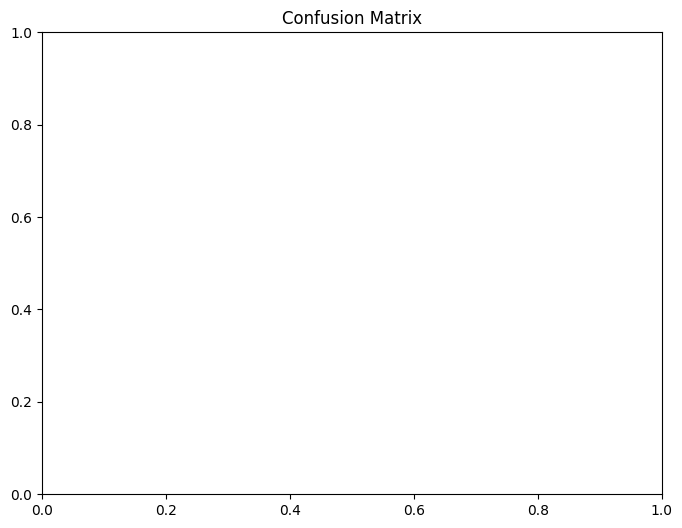

In [11]:
# Convert data to PyTorch tensors
# Replace these placeholders with your actual data
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5

# Initialize lists to store metrics
fold_accuracies = []
train_times = []
test_times = []
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Custom convolution layer with weight standardization
class Conv1dWS(nn.Conv1d):
    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return self._conv_forward(x, weight, self.bias)  # Pass self.bias here

# Define the CNN model with Group Normalization and Weight Standardization
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = Conv1dWS(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.groupnorm = nn.GroupNorm(num_groups=4, num_channels=32)
        self.fc = nn.Linear(32 * (input_size // 2), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.groupnorm(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 46  # Number of input features (adjust as needed)
    num_classes = len(np.unique(y.numpy()))  # Number of classes

    model = CNNModel(input_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 150
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            all_true_labels.extend(labels.tolist())
            all_predicted_labels.extend(predicted.tolist())

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        end_time = time.time()
        train_time = end_time - start_time
        train_times.append(train_time)

        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        start_time = time.time()

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        end_time = time.time()
        test_time = end_time - start_time
        test_times.append(test_time)

    fold_accuracies.append(test_accuracies[-1])

mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

total_test_loss = sum(test_losses)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)

mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (seconds): {mean_train_time:.2f}')
print(f'Mean Testing Time (seconds): {mean_test_time:.2f}')

mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/150_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/150_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()
# Plot confusion matrix
confusion = confusion_matrix(all_true_labels, all_predicted_labels)
disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_true_labels))
disp.plot(cmap='viridis', values_format='.0f')
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ML/Thesis/Detection/graphs/cnn2/150_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()